1. [Introducción](#intro)
1. [Descripción del dataset](#description)
1. [Integración y selección de los datos de interés a analizar](#integration)
1. [Carga del datos y librerías](#file)
1. [Limpieza de datos](#data-cleaning)

    5.1 [Elementos duplicados](#duplicated)

    5.2 [Valores extremos](#outliers)

    5.3 [Valores nulos o vacíos](#null)

    5.4 [Feature Engineering](#feature-eng)

1. [Análisis exploratorio](#eda)

    6.1 [Análisis descriptivo](#eda-descrip)

    6.2 [Análisis estadístico](#eda-statistics)

      6.2.1 [Análisis estadístico descriptivo](#eda-statistics-descrip)

      6.2.2 [Comprobación de la normalidad y homogeneidad de la varianza](#normal)

      6.2.3 [Aplicación de pruebas estadísticas](#tests)
        
1. [Conclusiones](#conclussion)

# Introducción <a class="anchor" id="intro"></a>

El siguiente documento recoge la realización de la Práctica 2 de la asignatura Tipología y ciclo de vida de los datos. En ella se elabora un caso práctico orientado a aprender a identificar los datos relevantes para un proyecto analítico y usar las herramientas de integración, limpieza, validación y análisis de las mismas. En ella se pondrán en práctica los conceptos aprendidos durante todo el semestre de la asignatura, realizando un análisis exploratorio de un dataset seleccionado y aplicando técnicas de análisis de datos.

La práctica ha sido realizada por **Alicia Contreras** y **Daniel García**.

# Descripción del dataset <a class="anchor" id="description"></a>

El dataset elegido para esta práctica ha sido *Spaceship Titanic*. Se trata de una de las competiciones de la página web Kaggle.

https://www.kaggle.com/competitions/spaceship-titanic

Se trata de una serie de datos de casi 13.000 pasajeros de una nave espacial en el año 2912, encargada de transportar emigrantes del sistema solar a tres exoplanetas habitables. Esta nave ha tenido un incidente por el cual gran parte de los pasajeros han sido enviados a otra dimensión.

El dataset contiene una variable objetivo que nos indica si un pasajero ha sido transportado a otra dimensión o no, con el objetivo de utilizar técnicas de ciencia de datos para predecirlo y evitar futuros desastres. Está compuesto por un total de 14 variables de las cuales encontramos

- Texto: 2 (una de ellas un identificador único de pasajero)
- Categóricas: 3
- Numéricas: 6
- Binarias: 3 (de las cuales una es la variable objetivo)

La descripción de estas variables se detalla a continuación.


- **PassengerId**: Un Id único para cada pasajero. Cada Id tiene la forma gggg_pp donde gggg indica el grupo con el que viaja el pasajero y pp es su número dentro del grupo. Las personas de un grupo suelen ser miembros de la familia, pero no siempre.
- **HomePlanet**: El planeta del que partió el pasajero, normalmente su planeta de residencia permanente.
- **CryoSleep**: Indica si el pasajero eligió ser puesto en animación suspendida durante el viaje. Los pasajeros en criosueño están confinados en sus camarotes.
- **Cabin**:  El número de camarote donde se aloja el pasajero. Tiene la forma cubierta/número/lado, donde el lado puede ser P para babor o S para estribor.
- **Destination**: El planeta al que desembarcará el pasajero.
- **Age**:  La edad del pasajero.
- **VIP**: Si el pasajero ha pagado por un servicio especial VIP durante el viaje.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**: Cantidad que el pasajero ha facturado en cada uno de los muchos servicios de lujo del Spaceship Titanic.
- **Name**: El nombre y los apellidos del pasajero.
- **Transported**: Si el pasajero fue transportado a otra dimensión. Este es el objetivo, la columna que se intenta predecir.

El problema que se pretende responder mediante la elección de este dataset es conseguir analizar las características principales que hacen que una persona vaya a ser transportada o no. Ver si se cumple algún tipo de similitudes en cuanto a rangos de edad, lugar de alojamiento, nivel adquisitivo... para tratar de ver las causas que han podido llevar a esta situación y tratar de prevenir problemas así en un futuro hipotético. Como trabajo futuro se podría entrenar un algoritmo de machine learning que en base a estas características, aprenda a predecir qué pasajeros serán transportados o no. No obstante, esta praćtica no recogerá el entrenameinto de ese algoritmo. 



# Integración y selección de los datos de interés a analizar <a class="anchor" id="integration"></a>


Se ha elegido este conjunto de datos ya que cumple con las características esperadas para plantear con él una tarea de ciencia de datos. El dataset es facilmente accesible, ya que los datos pueden descargarse directamente desde la página web de Kaggle. La información acerca de las variables del dataset y del objetivo de la competición están explicados con detalle. La variabilidad de la información que tenemos (variables categóricas, numéricas y booleanas) nos ha permitido realizar un análisis exploratorio de los datos completo y en profundidad. Por último, la temática de la competición nos ha parecido interesante y el hecho de realizar el análisis exploratorio para esta práctica nos servirá para realizar los primeros pasos de cara a participar en la competición.

# Carga del datos y librerías <a class="anchor" id="file"></a>

In [355]:
# Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.2)

from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
from scipy.stats import ttest_ind, chi2_contingency, shapiro, normaltest, levene
from sklearn.preprocessing import RobustScaler
from scipy.stats import chi2_contingency
import networkx as nx

import statsmodels.api as sm
import scipy

En la página fuente del dataset se proporcionan ya separados los datos de training y test. Sin embargo, de cara a realizar un EDA se realizará una unión de ambos subgrupos para formar un único dataset. Los datos del subconjunto de *test* no cuentan con información acerca de la variable objetivo por lo que aquellos análisis que incluyan la variable objetivo se realizarán únicamente en el conjunto de *training*.

In [356]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

df = pd.concat([df_train, df_test])

df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [357]:
print('Tamaño del conjunto de datos de entrenamiento:\t {}'.format(df_train.shape))
print('Tamaño del conjunto de datos de test:\t\t {}'.format(df_test.shape))
print('Tamaño del conjunto de datos final:\t\t {}'.format(df.shape))

Tamaño del conjunto de datos de entrenamiento:	 (8693, 14)
Tamaño del conjunto de datos de test:		 (4277, 13)
Tamaño del conjunto de datos final:		 (12970, 14)


# Limpieza de datos <a class="anchor" id="data-cleaning"></a>

En el siguiente apartado procederemos a realizar un análisis para ver si es necesario realizar una limpieza de datos. 

Para facilitar la selección de las distintas columnas, las agrupamos en 2 conjuntos: categóricas (cualitativas) y numéricas (cuantitativas).

In [358]:
# Agrupamos las columnas por tipos
categorical_cols = ["PassengerId", "HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP"]
numeric_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
target_col = "Transported"

**Destacar que aplicaremos los mismos procedimientos de limpieza al marco de datos general (df) y a los datos de entrenamiento (df_train) ya que va a ser el usado para analizar los datos de la variable objetivo.**

## Elementos duplicados <a class="anchor" id="duplicated"></a>


En primer lugar, comprobaremos si existen elementos duplicados en el dataset. Para ello utilizaremos la columna **PassengerId**. Se trata de un identificador único de cliente según las especificaciones del dataset. Vemos que esto se cumple, ya que no existe duplicidad en la columna. El resto de elementos del dataset si podrían estar duplicados por lo que con esta columna nos bastaría para ver que efectivamente, no existe duplicidad de registros.

In [359]:
df[df["PassengerId"].duplicated() == True].size

0

In [360]:
# Una vez comprobado que no se han duplicado los datos, prescindimos de las columna Name
# por no aportar información útil más allá de ser identificativa.
df = df.drop(['Name'], axis=1)
df_train = df_train.drop(['Name'], axis=1)

df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True


## Valores nulos o vacíos <a class="anchor" id="null"></a>

Comprobamos el número de valores vacíos o nulos que existen por cada una de las columnas:

In [361]:
# Comprobamos valores nulos
df.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Transported     4277
dtype: int64

Por lo general parece que existe una gran cantidad de valores nulos en las columnas, a pesar de que no supone un número excesivamente alto con respecto al total de registros. Cabe destacar que la gran cantidad de valores nulos en la variable objetivo **se corresponden con los registros del conjunto de test**, por lo que pantendremos esos registros intactos y se excluirán de los analisis que se hagan de dicha variable.

Tal y como observamos a continuación, no hay muchas columnas con más de 3 valores nulos.

In [362]:
df[df.isna().sum(axis=1) > 3]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
488,1050_01,NaN,True,G/157/P,TRAPPIST-1e,NaN,False,0.0,0.0,NaN,0.0,0.0,NaN
2042,4412_01,Earth,False,F/907/P,NaN,19.0,NaN,9.0,3.0,0.0,1390.0,NaN,NaN


Teniendo en cuenta las características del dataset, se han tomado las siguientes decisiones de diseño sobre el tratamiento de valores nulos:

- Los registros que no contengan la variable numérica **Age** se reemplazarán los valores nulos por la media de edad de todos los pasajeros de la nave.
- Las variables numéricas relacionadas con los gastos de los pasajeros en los dervicios de lujo de la nave **RoomService, FoodCourt, ShoppingMall, Spa y VRDeck** se sustituirán por 0. Se asumirá que los clientes que no tengan información en estas variables es porque no se han gastado nada en ellos.
- Para las variables categóticas se mantendrán los nulos, ya que el hecho de que los valores estén a nulo puede ofrecernos información importante. En las variables no booleanas **HomePlanet, CryoSleep, Cabin y Destination** se sustituirán los nulos por la etiqueta "Desconocido".

In [363]:
# Sustituir nan en las variables categoricas por la el valor Desconocido. En el caso de 'HomePlanet' y 'Destination' se usarán strings más descriptivos
for col in categorical_cols:
    fill_str = 'Desconocido'
    if col == 'HomePlanet':
        fill_str = 'Origen desconocido'
    elif col == 'Destination':
        fill_str = 'Destino desconocido'
                
    df[col] = df[col].fillna(fill_str)
    df_train[col] = df_train[col].fillna(fill_str)


    
# Sustituir nan en las variables numericas por la media
for col in numeric_cols:
    if col != "Age":
        df[col] = df[col].fillna(0)
        df_train[col] = df_train[col].fillna(0)
    
# Sistituir nan en Age por la media
df["Age"]=df["Age"].fillna(df["Age"].mean())
df_train["Age"]=df_train["Age"].fillna(df_train["Age"].mean())

df.isnull().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported     4277
dtype: int64

Para poder trabajar con los datos binarios False y True, sustituimos estos valores por 0 y 1, respectivamente, en las columnas correspondientes, incluída la variable objetivo *Transported*.

In [364]:
# Sustituimos valores de True-False por 1 o 0
df["CryoSleep"] = df["CryoSleep"].map(lambda x: 1 if x==True else 0)
df["VIP"] = df["VIP"].map(lambda x: 1 if x==True else 0)
df["Transported"] = df["Transported"].map(lambda x: 1 if x==True else 0)

df_train["CryoSleep"] = df_train["CryoSleep"].map(lambda x: 1 if x==True else 0)
df_train["VIP"] = df_train["VIP"].map(lambda x: 1 if x==True else 0)
df_train["Transported"] = df_train["Transported"].map(lambda x: 1 if x==True else 0)

df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1



## Valores extremos <a class="anchor" id="outliers"></a>

A continuación queremos comprobar la existencia de valores extremos, ya que esto puede afectar en gran medida el análisis posterior.

<AxesSubplot:xlabel='VRDeck'>

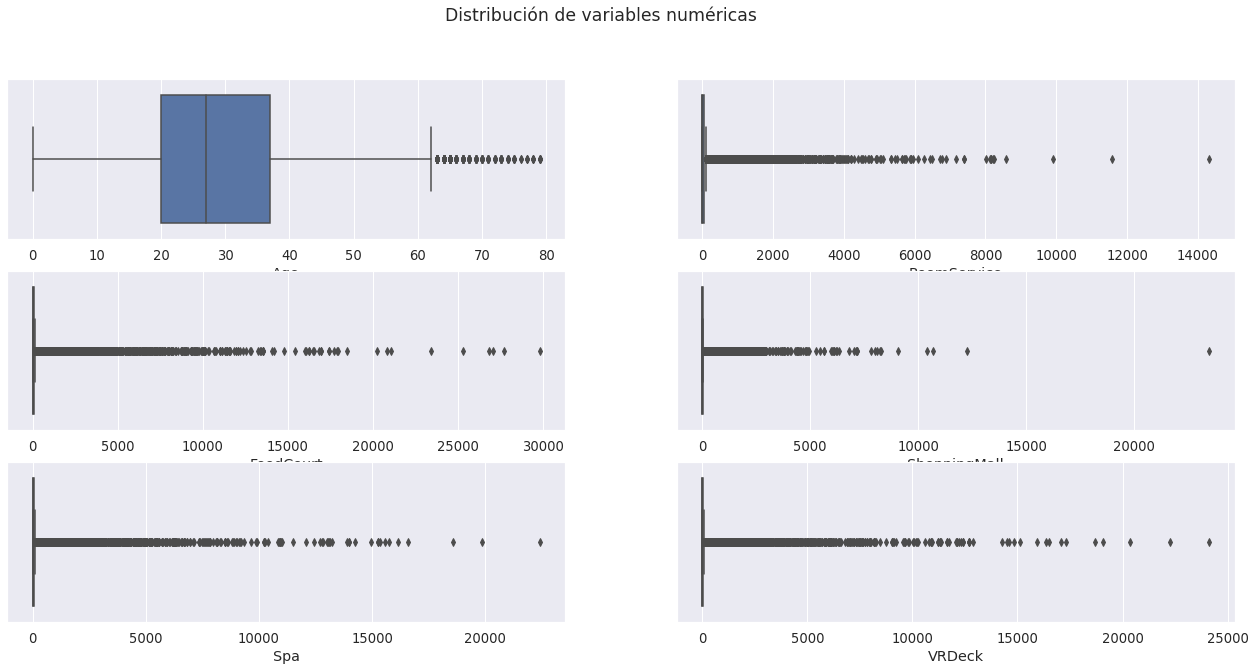

In [365]:
fig, axes = plt.subplots(3, 2, figsize=(22, 10))

fig.suptitle('Distribución de variables numéricas')

sns.boxplot(ax=axes[0, 0], data=df, x='Age')
sns.boxplot(ax=axes[0, 1], data=df, x='RoomService')
sns.boxplot(ax=axes[1, 0], data=df, x='FoodCourt')
sns.boxplot(ax=axes[1, 1], data=df, x='ShoppingMall')
sns.boxplot(ax=axes[2, 0], data=df, x='Spa')
sns.boxplot(ax=axes[2, 1], data=df, x='VRDeck')

Tal y como podemos ver en la representación de los boxplots de las variables numéricas, existen gran cantidad de valores considerados atípicos en las relacionadas con las cantidades de dinero gastadas por los clientes. Podría considerarse eliminar los valores a partir de un rango, pero sin embargo, teniendo en cuenta el dominio del problema y al tratarse de cantidades monetarias se puede asumir que realmente hay clientes con mucho dinero que pueden asumir esa clase de gastos. En relación a la variable "age", los valores considerados atípicos en el boxplot están dentro del rango de edades posibles para una persona, por lo que los mantendremos. 

Los únicos valores que no podrían ser válidos serían menos que 0, pues significaría que les han pagado por utilizar los servicios o que hay personas que menos de 0 años.

In [366]:
df[df[numeric_cols] < 0][numeric_cols].sum()

Age             0.0
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

Los valores outliers de las columnas de cargos en los distintos servicios no son reemplazados ni ignorados porque aportan información valiosa y coherente, ya que los pasajeros pueden tener niveles muy distintos de poder adquisitivo. 

Los únicos valores que no podrían ser válidos serían menos que 0, pues significaría que les han pagado por utilizar los servicios o que hay personas que menos de 0 años: 

## Feature Engineering <a class="anchor" id="feature-eng"></a>

En este apartado generamos columnas nuevas nuevas a partir de las ya existentes para simplificar o ampliar la información que proporcionan de cara al análisis de los datos.

Con el ID del pasajero podemos obtener el grupo al que pertenecen y, por tanto, calculamos el tamaño del grupo al que pertenece cada uno de los pasajeros. Como ésta es la única información importante que aporta el PassengerId, prescindimos de esta columna.

In [367]:
df['Group'] = df['PassengerId'].str[:4]
df["GroupSize"] = df["Group"].map(lambda x: df['Group'].value_counts()[x])
df = df.drop(columns=['Group', 'PassengerId'], axis=1)

df_train['Group'] = df_train['PassengerId'].str[:4]
df_train["GroupSize"] = df_train["Group"].map(lambda x: df_train['Group'].value_counts()[x])
df_train = df_train.drop(columns=['Group', 'PassengerId'], axis=1)

df.head(2)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize
0,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1
1,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1


De la columna Cabin obtenemos el lado en que está la cabina (babor o estribor) a partir del último caracter.

In [368]:
# Lugar de la cabina
df['Cabin'] = df['Cabin'].str[-1:]
df["CabinOrientation"] = df["Cabin"].map(lambda x: 'Estribor' if x=='S' else ('Babor' if x=='P' else 'Desconocido'))
df = df.drop(columns=['Cabin'], axis=1)

df_train['Cabin'] = df_train['Cabin'].str[-1:]
df_train["CabinOrientation"] = df_train["Cabin"].map(lambda x: 'Estribor' if x=='S' else ('Babor' if x=='P' else 'Desconocido'))
df_train= df_train.drop(columns=['Cabin'], axis=1)

df.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize,CabinOrientation
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,Babor
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,Estribor


Por último, crearemos una variable **Total_spent** que será la suma de gastos en los servicios **RoomService, FoodCourt, ShoppingMall, Spa y VRDeck.**

In [369]:
df["Total_spent"] = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
df_train["Total_spent"] = df_train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck","Total_spent"]].head(3)

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_spent
0,0.0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0,736.0
2,43.0,3576.0,0.0,6715.0,49.0,10383.0


# Análisis exploratorio  <a class="anchor" id="eda"></a>

## Análisis descriptivo <a class="anchor" id="eda-descrip"></a>

En esta sección realizaremos un análisis gráfico y comparativo de las diferentes variables del dataset. Comenzaremos por el análisis de las distribuciones de las variables numéricas y las categóricas de manera individual, para intentar comprender mejor los rangos y los valores de las variables así como su distribución. Se realizarán comparaciones y agrupaciones de algunas variables para intentar extraer conclusiones conjuntas. Finalmente se hará un estudio comparativo de algunas de las variables en base a la variable objetivo **Transported**, para tratar de encontrar diferencias y similitudes ambos grupos de personas: los que han sido transportados a otra dimensión y los que no.

En primer lugar, analizaremos el objetivo del viaje en transbordador, que es viajar a otro planeta. Tenemos la información del planeta de origen de cada pasajero así como el planeta al que viaja.

<AxesSubplot:xlabel='Destination', ylabel='count'>

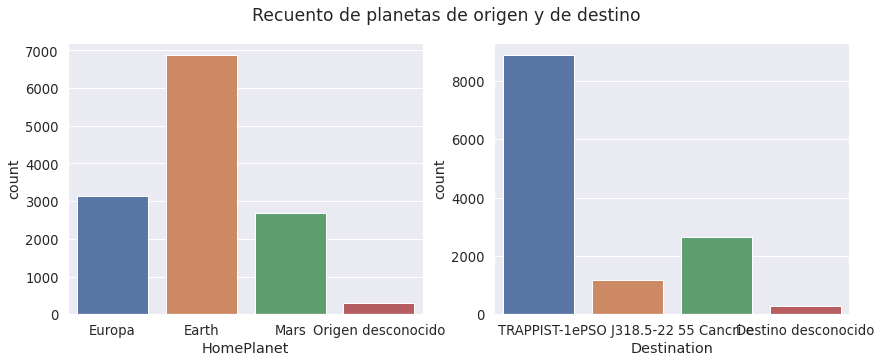

In [370]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle('Recuento de planetas de origen y de destino')


sns.countplot(ax=axes[0], data=df, x='HomePlanet')
sns.countplot(ax=axes[1], data=df, x='Destination')

Podemos ver que la gran mayoría de pasajeros provienen del planeta Tierra, Earth. El resto provienen de los planetas Europa y Marte, en proporciones similares. Existe una pequeñá porción de pasajeros de los que se desconoce su planeta de proveniencia. En cuanto a los planetas de destino, podemos ver que el más común con diferencia al que se dirige la gente es TRAPPIST-1e. Existe bastante diferencia con respecto a los otros dos planetas. También existe un número reducido de personas de las que se desconoce el destino al que se dirigen. Es extraño el hecho de que existan personas de las que se desconocen estos datos, ya que se entiende que el único motivo de viajar en esta nave es trasladarse a otro planeta. POdría tratarse sin embargo de los empleados de la tripulación o el personal de la nave.

Queremos observar también las combinaciones más típicas entre origen y destino, para lo cual representaremos los valores en un grafo relacional.

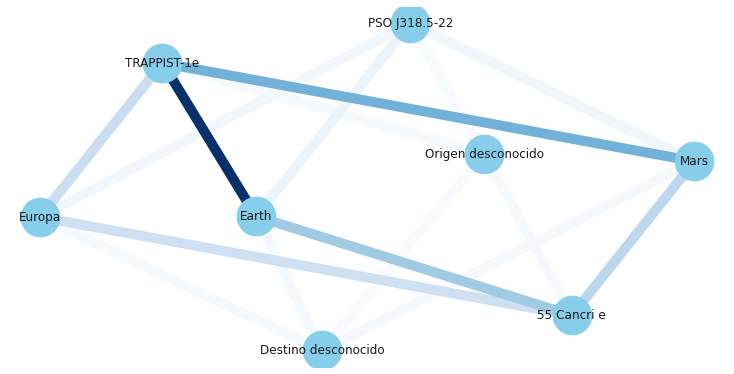

In [371]:
df_aux = df[['HomePlanet', 'Destination']]

destination_graph=df_aux.value_counts().reset_index()
destination_graph.columns = ['HomePlanet', 'Destination', 'Total']
destination_graph=destination_graph.sort_values(by=['Total'])

plt.figure(3,figsize=(10,5)) 

G=nx.from_pandas_edgelist(destination_graph, 'HomePlanet', 'Destination', create_using=nx.Graph() )
 
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_color=destination_graph['Total'], width=10.0, edge_cmap=plt.cm.Blues)
plt.show()

El grafo representa el conteo de origen-destino por tonalidades de color, cuanto más oscuro más concurrido. Vemos que como era de esperar, el planeta de partida más común, Earth coincide con el planeta de destino más común TRAPPIST-1e como combinación de viaje más concurrida. El segundo destino más común para personas que habitan en la Tierra es el planeta 55 Cancri e.

También existe mucha gente que viaja desde Marte a TRAPPIST-1e, con 55 Cancri e como segunda opción de destino. Por lo que parece, el planeta PSO J318 5-22 no es un destino tan llamativo como los otros dos planetas. En el caso de las personas de las que no sabemos su destino y/o su origen, se puede apreciera que no son un número grande.

También nos interesa saber la distribución de edad en función del destino. ¿Hay algún destino que sea preferido por gente mayor o por gente joven?

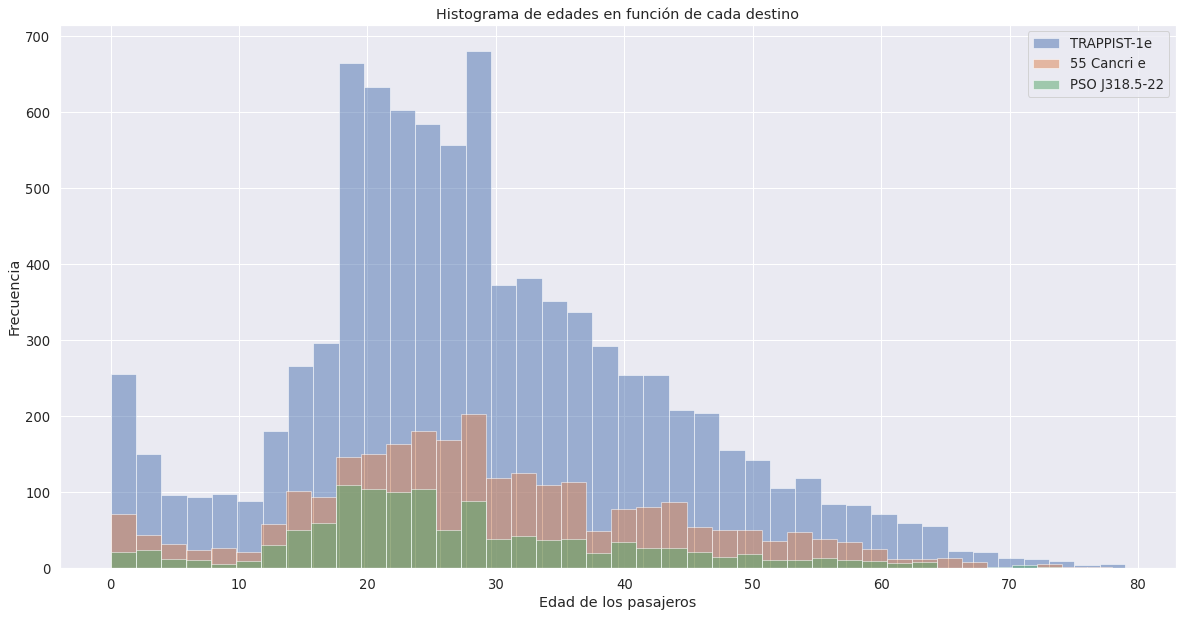

In [372]:
plt.figure(3,figsize=(20,10)) 

plt.hist(df['Age'][df['Destination']=="TRAPPIST-1e"], alpha=0.5, density=False, bins=40, label="TRAPPIST-1e")
plt.hist(df['Age'][df['Destination']=="55 Cancri e"], alpha=0.5, density=False, bins=40, label="55 Cancri e")
plt.hist(df['Age'][df['Destination']=="PSO J318.5-22"], alpha=0.5, density=False, bins=40, label="PSO J318.5-22")
plt.ylabel('Frecuencia')
plt.xlabel('Edad de los pasajeros')
plt.title("Histograma de edades en función de cada destino")
plt.legend(loc='upper right')
plt.show()

Por lo que podemos ver, los tres destinos tienen exactamente la misma forma. Los tres tienen la misma distribución. Esto puede indicarnos que no existe ningún motivo por el cual una persona más joven o más mayor prefiera irse a un planeta o a otro, y que al parecer es común que las familias viajen juntas y por tanto haya distribuciones muy similares en los tres.

Entre los pasajeros con destino a los tres planetas se puede observar que exite un pico de niños recien nacidos, que se reduce bastante entre las edades de entre los 3 y los 11 años. Se observa un gran aumento de densidad de población en las edades de entre 19 y 29 años, con un pico en este último año de edad muy acusado y que destaca por encima del resto de franjas de edad en los tres planetas de destino. Con respecto al resto de edades, podemos ver cómo la frecuencia va disminuyendo suavemente hasta llegar a los 80 años, el máximo de la edad de las personas del dataset.

Queremos comparar el nivel económico de los pasajeros que se alojan a ambos lados de la nave. Para ello utilizamos la columna con la orientación de la cabina.

In [373]:
df_aux = df[['CabinOrientation', 'VIP']]

bars=df_aux.value_counts().reset_index()
bars.columns = ['CabienOrientation', 'VIP', 'Total']
bars[bars['VIP']==1]

,CabienOrientation,VIP,Total
3,Babor,1,142
4,Estribor,1,124
5,Desconocido,1,7


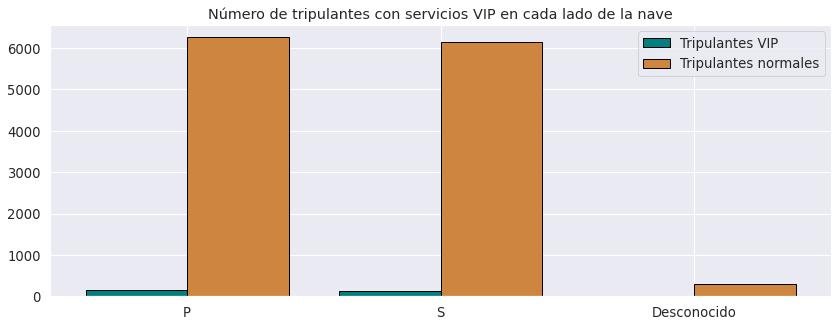

In [374]:
plt.figure(3,figsize=(14,5)) 

x = np.arange(3)

plt.bar(x-0.2, bars['Total'][bars['VIP']==1], color='teal', width=0.4, edgecolor='black', label='Tripulantes VIP')
plt.bar(x+0.2, bars['Total'][bars['VIP']==0], color='peru', width=0.4, edgecolor='black', label='Tripulantes normales')
plt.xticks(x,['P', 'S', 'Desconocido'])
plt.title('Número de tripulantes con servicios VIP en cada lado de la nave')

plt.legend()
plt.show()

Tal y como podemos observar, la cantidad de tripulantes que han contratado los servicios VIP del crucero son muy pocos, por lo que tampoco se aprecian comparaciones destacables. Si que podemos ver sin embargo que hay más personas que han contratado los servicios VIP alojadas en babor que en estribor. La mayoría de la gente de la que desconocemos el lado en el que se aloja no ha contratado estos servicios.

Vamos a ver si esta tendencia ocurre también a la hora de la contratación de otros servicios en la nave. Para ello usaremos la columna previamente creada **Total_spent**, que equivale al total de los gastos en los servicios de cada pasajero.

<AxesSubplot:title={'center':'Dinero gastado en servicios por los tripulantes VIP y no VIP en cada lado de la nave'}, xlabel='CabinOrientation', ylabel='Total_spent'>

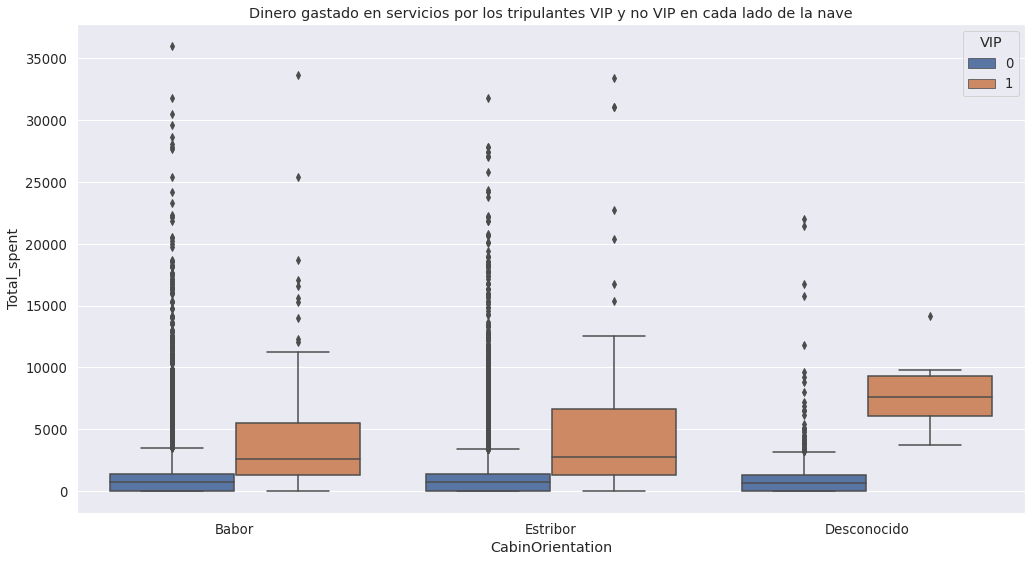

In [375]:
plt.figure(3,figsize=(17,9))
plt.title('Dinero gastado en servicios por los tripulantes VIP y no VIP en cada lado de la nave')

sns.boxplot(x='CabinOrientation', y='Total_spent', hue='VIP', data=df)

Como era de esperar, las personas que han contratado los servicios VIP de la nave suelen gastarse cantidades más altas de dinero en actividades complementarias, por lo que se entiende que se trata de tripulantes con un poder adquisitivo alto. Para cualquiera de los lados de camarotes de la nave, el 75% de personas no VIP se han gastado lo mismo que el 25% de personas VIP. Esto quiere decir que los gastos de las personas VIP son bastante superiores a los de las personas no VIP independientemente del lado en el que se alojen. El nivel adquisitivo de ambos lados de la nave parece ser similar aunque las personas que se alojan en la parte de estribor (S) despuntan un poco por arriba, por lo que suelen gastarse un poco maś. Contrastando esta información con el recuento anterior de personas VIP, llegamos a la conclusión de que en el lado de estribor, a pesar de haber un menor número de personas VIP, suelen gastarse más en servicios.

En esta misma línea, nos interesa saber el dinero gastado en diferentes servicios por los tripulantes según su destino y su origen.

[Text(0, 0, 'TRAPPIST-1e'),
 Text(1, 0, 'PSO J318.5-22'),
 Text(2, 0, '55 Cancri e'),
 Text(3, 0, 'Destino desconocido')]

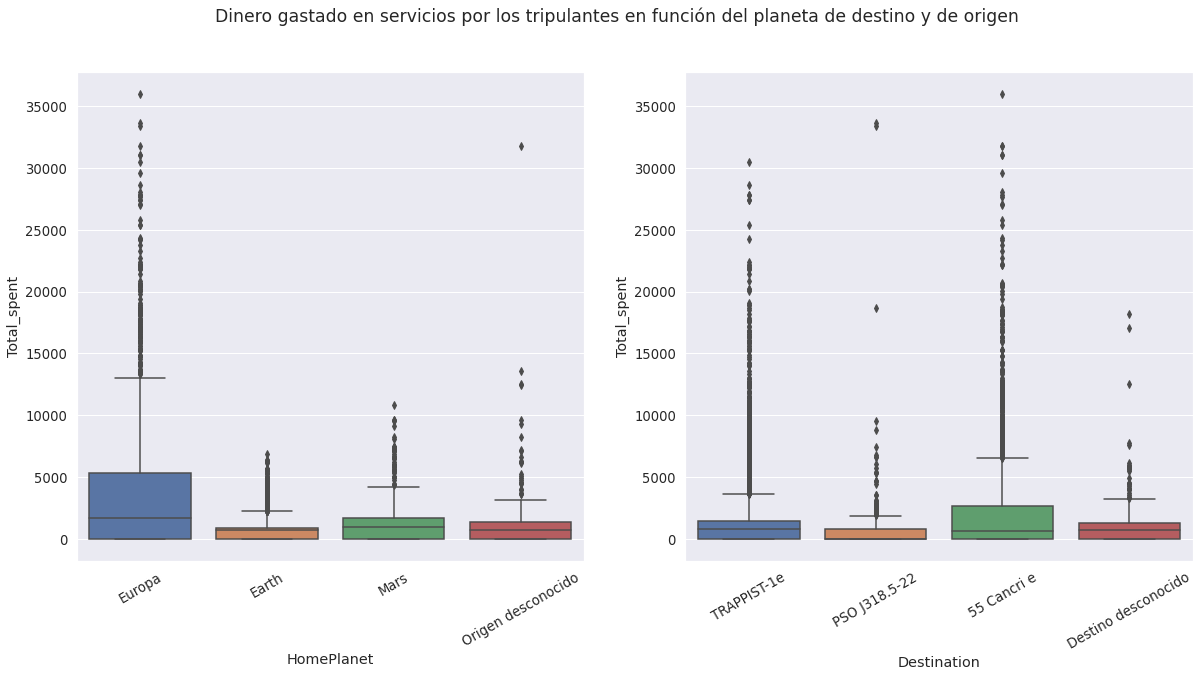

In [376]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

fig.suptitle('Dinero gastado en servicios por los tripulantes en función del planeta de destino y de origen')


ax=sns.boxplot(ax=axes[0], x='HomePlanet', y='Total_spent', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax=sns.boxplot(ax=axes[1], x='Destination', y='Total_spent', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

En cuanto al **planeta de origen**, destaca con diferencia las cantidades gastadas en servicios por las personas provenientes de Europa. No solo el rango intercuartílico recoge el rango de valores más altos que el resto si no que además, cuenta con una gran cantidad de outliers que corresponden a personas que han llegado a gastarse cantidades superiores a los 25.000 euros (asumiendo que esa sea la moneda utilizada). Las personas que menos se han gastado en general son aquellas provenientes de la Tierra, a pesar de que como observamos al analizar los planetas de origen, la mayoría de tripulantes eran terrícolas.

En cuanto a la división por **planeta de destino**, podemos ver que los gastos están un poco más diversificados, no existe tanta diferenciación. Los tripulantes que se dirigen a 55 Cancri e parecen gastar más pero realmente cuentan con un nivel más alto de dispersión debido a la gran cantidad de outliers presentes en los datos de este grupo.

Finalmente, observaremos la media de gastos divididos en cada uno de los diferentes servicios en función de la edad, con el objetivo de identificar posibles tendencias.

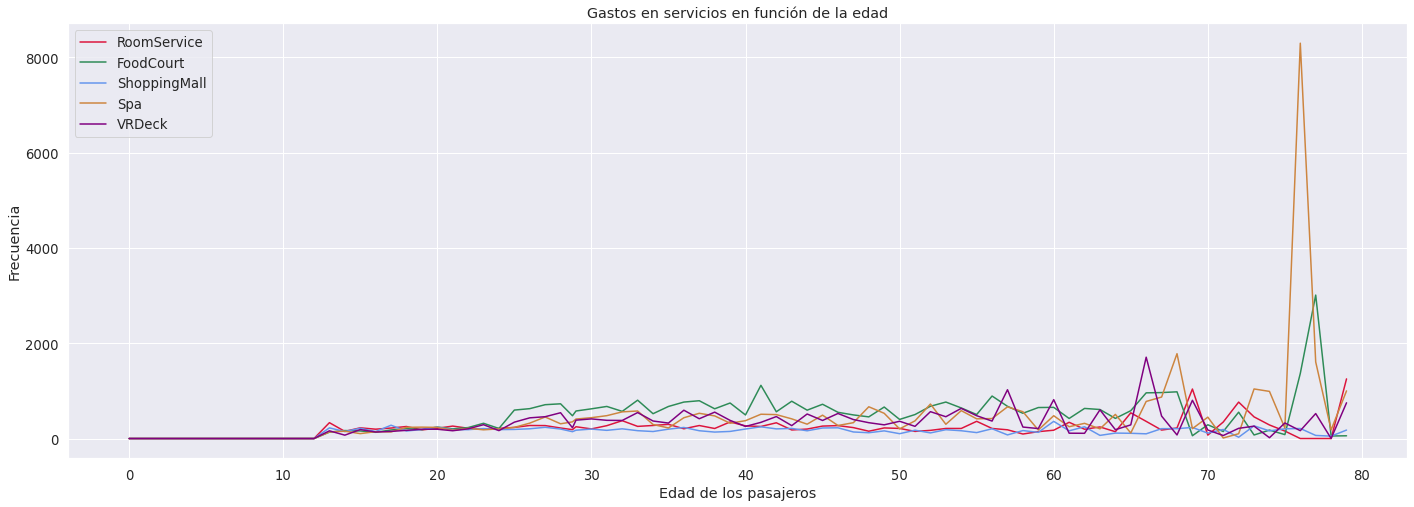

In [377]:
plt.figure(3,figsize=(24,8)) 

room_age=df.groupby('Age')['RoomService'].mean()
food_age=df.groupby('Age')['FoodCourt'].mean()
shopping_age=df.groupby('Age')['ShoppingMall'].mean()
spa_age=df.groupby('Age')['Spa'].mean()
vdeck_age=df.groupby('Age')['VRDeck'].mean()

plt.plot(room_age, color='crimson', label='RoomService')
plt.plot(food_age, color='seagreen', label='FoodCourt')
plt.plot(shopping_age, color='cornflowerblue', label='ShoppingMall')
plt.plot(spa_age, color='peru', label='Spa')
plt.plot(vdeck_age, color='purple', label='VRDeck')

plt.ylabel('Frecuencia')
plt.xlabel('Edad de los pasajeros')
plt.title("Gastos en servicios en función de la edad")
plt.legend(loc='upper left')
plt.show()

Es evidente que hasta los 13 años no se comienzan a tener gastos relacionados con los servicios. A partir de esa edad, los gastos son bastante bajos y uniformes (no hay un servicio que destaque por encima de los otros). A partir de los 24-25 años de edad, comienza un aumento de los gastos en servicios extra especialmente el de restauración (FoodCourt). En general ,los gastos medios más pequeños son realizados en compras en el centro comercial mientras que los gastos en comida son los más recurrentes a lo largo de todas las edades. Parece ser bastante común también el gasto en VRDeck especialmente entre las edades de 55-70 años y el gasto en Spa entre las edades de entre 65 y 80 años. Es llamativa la cantidad de dinero gastado en el rango de edad 72-77 años en este servicio, tal y como podemos observar en el pico amarillo de la derecha.

Toda esta información relativa a gastos de los tripulantes podría utilizarse para realizar una segmentación de clientes y saber a qué tipo de cliente promocionar los servicios de la nave.

<AxesSubplot:title={'center':'Matriz de correlación de variables numéricas'}>

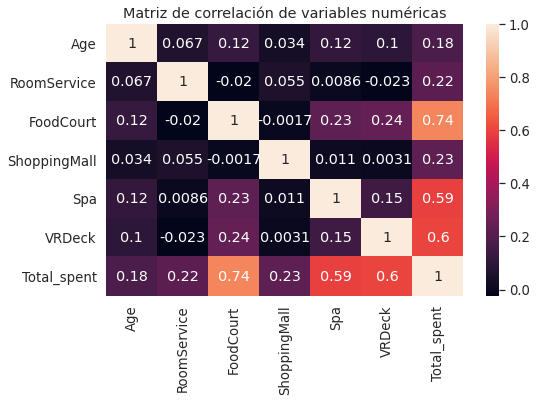

In [378]:
numeric_cols.append('Total_spent')

plt.figure(figsize=(8,5))
corr = df[numeric_cols].corr()

plt.title('Matriz de correlación de variables numéricas')
sns.heatmap(corr,  annot=True)

Por último, hemos dibujado una matriz de correlación entre las variables numéricas para ver hasta que punto podemos decir que están correlacionadas. Observamos que en general no existe una correlación muy alta entre las variables numéricas. Las correlaciones más altas se dan entre las variables **Spa** y **FoodCourt**, que son los gastos más recurrentes como hemos visto anteriormente y entre **VRDeck** y **FoodCourt**. Los gastos más correlacionados con la edad son precisamente los primeros comentados, **Spa** y **FoodCourt**.

A continuación, como hemos comentado anteriormente, vamos a analizar la variable objetivo **Transported**.

En primer lugar, obtenemos la distribución de los de la variable para comprobar si los valores están balanceados o no. Esta comprobación solo se realiza sobre los datos de entrenamiento, ya que el conjunto de test no dispone de esta variable.

<AxesSubplot:title={'center':'Distribucion de Transported'}, ylabel='Transported'>

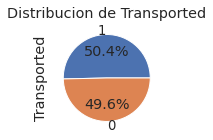

In [379]:
# Distribucion de la variable objetivo

plt.figure(figsize=(2,2))
df_train['Transported'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Distribucion de Transported')

Podemos ver que la variable objetivo está muy balanceada. Esto puede evitar numerosos problemas en un futuro a la hora del análisis y de las pruebas estadísticas. Además, en caso de llegar a entrenar un algoritmo de clasificación por ejemplo, el hecho de que la variable de clasificación esté balanceada hará que se eviten sesgos en el entrenamiento del algoritmo.

A continuación, exploramos la relación de la variable objetivo **Transported** con el resto de variables para intentar extraer relaciones y conclusiones.

Comenzamos con las variables cualitativas:

<AxesSubplot:title={'center':'Pasajeros no criogenizados'}, ylabel='Transported'>

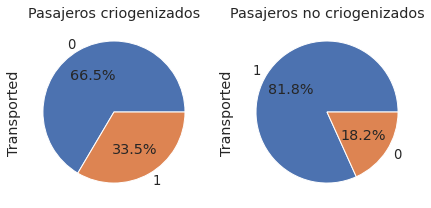

In [380]:
# En funcion de si los pasajeros estaban criogenizados o no
fig, axs = plt.subplots(1, 2, figsize=(7,5))
df_train[df_train['CryoSleep'] == 0]['Transported'].value_counts().plot(kind='pie', 
                                                                         autopct='%1.1f%%', 
                                                                         title='Pasajeros criogenizados',
                                                                         ax=axs[0])

df_train[df_train['CryoSleep'] == 1]['Transported'].value_counts().plot(kind='pie', 
                                                                         autopct='%1.1f%%', 
                                                                         title='Pasajeros no criogenizados',
                                                                         ax=axs[1])

Del gráfico superior vemos que hay una diferencia muy significativa entre los pasajeros en animación suspendida y los que no, porque más de la mitad (67%) de los criogenizados no fueron transportados a otra dimensión mientras que sólo el 18% de los no criogenizados se salvaron.

Porcentaje de pasajeros VIP del total: 2.289198205452663


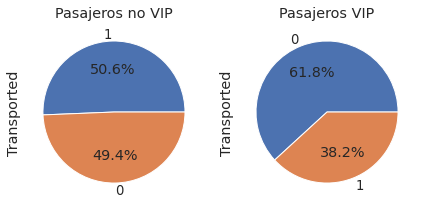

In [381]:
# En funcion de si los pasajeros eran de clase VIP o no
fig, axs = plt.subplots(1, 2, figsize=(7,4))
df_train[df_train['VIP'] == 0]['Transported'].value_counts().plot(kind='pie', 
                                                                         autopct='%1.1f%%', 
                                                                         title='Pasajeros no VIP',
                                                                         ax=axs[0])

df_train[df_train['VIP'] == 1]['Transported'].value_counts().plot(kind='pie', 
                                                                         autopct='%1.1f%%', 
                                                                         title='Pasajeros VIP',
                                                                         ax=axs[1])

pct_vip = df_train[df_train['VIP']==1].shape[0] / df_train.shape[0]
print("Porcentaje de pasajeros VIP del total: {}".format(pct_vip*100))

Hay un menor porcentaje de pasajeros VIP que fueron transportados a otra dimensión en comparación con los pasajeros corrientes, pero no deberíamos tomar este dato como algo significativo por el reducido número de pasajeros VIP. En comparación con el total, suponen un poco más de un 2% del total.

Partiendo de la información obtenida en los análisis del dineor gastado en función del destino y el origen, se observan diferencias entre los distintos grupos, lo que podría influir en si fueron transportados o no según estas características.

<AxesSubplot:xlabel='Destination', ylabel='count'>

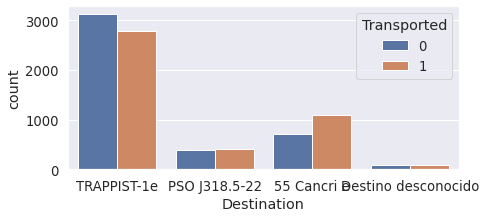

In [382]:
plt.figure(figsize=(7,3))
sns.countplot(data=df_train, x='Destination', hue='Transported')

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

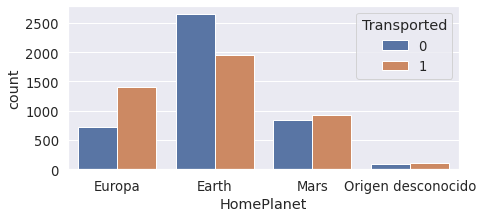

In [383]:
plt.figure(figsize=(7,3))
sns.countplot(data=df_train, x='HomePlanet', hue='Transported')

Dado que el tráfico más numeroso es desde La Tierra a TRAPPIST-1e, vamos a comprobar si se han visto muy afectados por la transportación:

<AxesSubplot:xlabel='Transported', ylabel='count'>

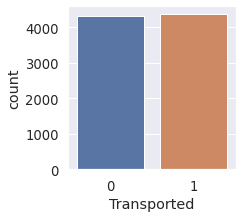

In [384]:
df_aux = df_train[(df_train['HomePlanet'] == "Earth") & (df_train['Destination'] == "TRAPPIST-1e")]

plt.figure(figsize=(3,3))
sns.countplot(data=df_train, x='Transported')

La diferencia que mejor se aprecia es en los pasajeros que provienen de Europa, ya que practicamente **se han transportado el doble de pasajeros de los que se han salvado**. En el resto de planetas (origen y destino) se ven diferencias pero ninguna tan significativa como ésta.

Dado que por ahora las diferencias más importantes se han observado entre los planetas de destino y en entre los criogenizados y los que no, vamos a juntar ambos criterios para ver si podemos obtener más información que por separado. 

Text(0.5, 1.0, 'Pasajeros no Criogenizados por planeta de Origen')

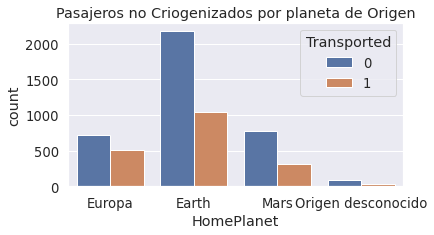

In [385]:
df_aux = df_train.loc[(df_train['CryoSleep'] == False)]


plt.figure(figsize=(6,3))
sns.countplot(data=df_aux, x='HomePlanet', hue='Transported')
plt.title("Pasajeros no Criogenizados por planeta de Origen")

Text(0.5, 1.0, 'Pasajeros Criogenizados por planeta de Origen')

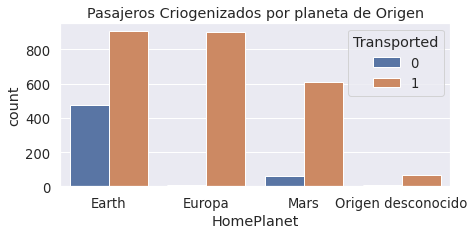

In [386]:
df_aux = df_train.loc[(df_train['CryoSleep'] == 1)]


plt.figure(figsize=(7,3))
sns.countplot(data=df_aux, x='HomePlanet', hue='Transported')
plt.title("Pasajeros Criogenizados por planeta de Origen")

Parece que hemos encontrado un par de grupos que fueron casi transportados a otra dimensión por completo. De los pasajeros que venían de Europa y Marte, especialmente los de Europa, y que estaban criogenizados se han transportado una amplia mayoría, concretamente:

In [387]:
pct_eu = df_train[(df_train['CryoSleep']==True) & (df_train['HomePlanet']=="Europa") & (df_train['Transported']==True)].shape[0] / df_train[(df_train['CryoSleep']==True) & (df_train['HomePlanet']=="Europa")].shape[0]
pct_mars = df_train[(df_train['CryoSleep']==True) & (df_train['HomePlanet']=="Mars") & (df_train['Transported']==True)].shape[0] / df_train[(df_train['CryoSleep']==True) & (df_train['HomePlanet']=="Mars")].shape[0]

print("Porcentaje de pasajeros criogenizados de Europa que han sido transportados: {} %".format(pct_eu*100))
print("Porcentaje de pasajeros criogenizados de Marte que han sido transportados: {} %".format(pct_mars*100))

Porcentaje de pasajeros criogenizados de Europa que han sido transportados: 98.90230515916575 %
Porcentaje de pasajeros criogenizados de Marte que han sido transportados: 91.18086696562034 %


Para acabar con las variables cualitativas, utilizamos la información que hemos obtenido de la Cabina referente a su orientación para comprobar visualmente si ha influido en la variable objetivo. Este criterio lo aplicamos sobre los pacientes en animación suspendida, pues son los que estaban con toda seguridad en sus cabinas, como se especifica en la descripción de los datos:

<AxesSubplot:xlabel='CabinOrientation', ylabel='count'>

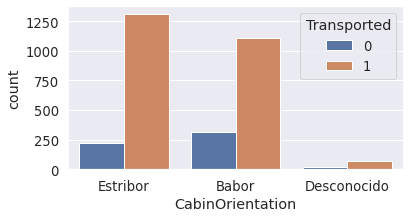

In [388]:
plt.figure(figsize=(6,3))
sns.countplot(data=df_train[df_train['CryoSleep'] == 1], x='CabinOrientation', hue='Transported')

A continuación pasamos a las variables cuantitativas, más concretamente a la edad de los pasajeros **Age**, la cantidad de dinero gastada en los servicios Premium de la nave **Total_spent** y el tamaño del grupo **GroupSize**.

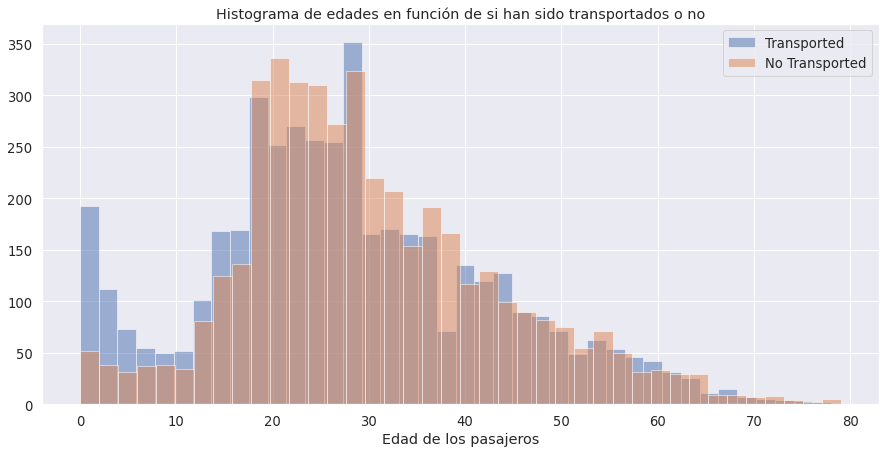

In [389]:
plt.figure(figsize=(15,7)) 

plt.hist(df_train['Age'][df_train['Transported']==1], alpha=0.5, density=False, bins=40, label="Transported")
plt.hist(df_train['Age'][df_train['Transported']==0], alpha=0.5, density=False, bins=40, label="No Transported")
plt.xlabel('Edad de los pasajeros')
plt.title("Histograma de edades en función de si han sido transportados o no")
plt.legend(loc='upper right')
plt.show()

En proporción, los que más han sido transportados han sido los primeros grupos de edad, cuando en el resto de los pasajeros no se aprecia una diferencia importante. 

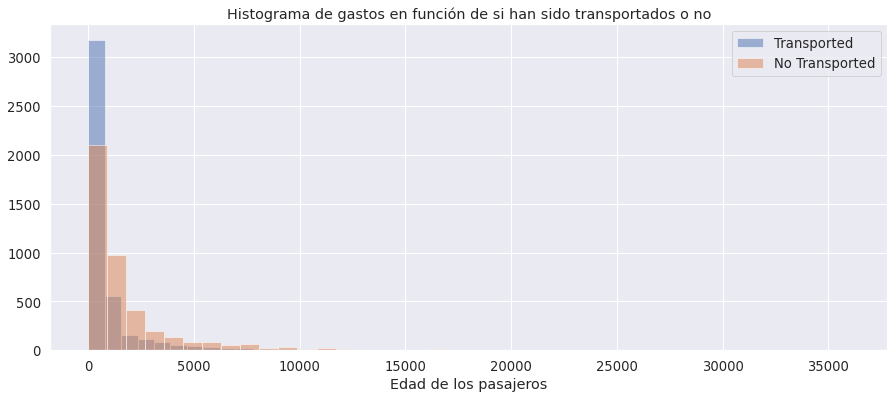

In [390]:
plt.figure(figsize=(15,6)) 

plt.hist(df_train['Total_spent'][df_train['Transported']==1], alpha=0.5, density=False, bins=40, label="Transported")
plt.hist(df_train['Total_spent'][df_train['Transported']==0], alpha=0.5, density=False, bins=40, label="No Transported")
plt.xlabel('Edad de los pasajeros')
plt.title("Histograma de gastos en función de si han sido transportados o no")
plt.legend(loc='upper right')
plt.show()

La presencia de los valores extremos nos dificulta el análisis visual y entorpece la representación gráfica, sin embargo se puede apreciar que los transportados se agrupan en los valores más bajos de gasto (que también suponen gran parte de los datos) mientras que la proporción de los transportados sobre los no transportados en el resto de pasajeros es muy baja.

Por último, vamos a comprobar la información del tamaño del grupo nos aporta alguna información nueva:

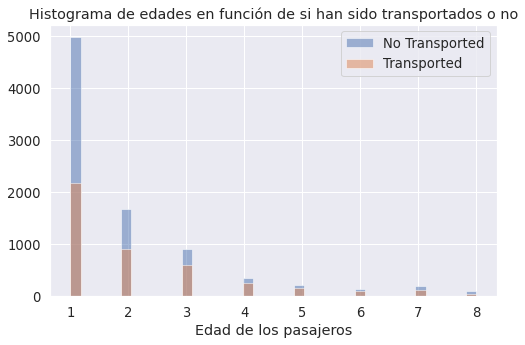

In [391]:
plt.figure(3,figsize=(8,5)) 

plt.hist(df['GroupSize'][df['Transported']==0], alpha=0.5, density=False, bins=40, label="No Transported")
plt.hist(df['GroupSize'][df['Transported']==1], alpha=0.5, density=False, bins=40, label="Transported")
plt.xlabel('Edad de los pasajeros')
plt.title("Histograma de edades en función de si han sido transportados o no")
plt.legend(loc='upper right')
plt.show()

En proporción, los que más han sido transportados han sido los grupos con tamaño 3, 4, y 5 y en el resto parece haber el mismo número de transportados y que de no transportados.

## Análisis estadístico <a class="anchor" id="eda-statistics"></a>



En la siguiente sección se realizará un análisis del dataset desde un enfoque más estadístico.

### Análisis estadístico descriptivo <a class="anchor" id="eda-statistics-descrip"></a>

Comenzaremos por analizar las distribuciones de las diferentes variables numéricas, así como los valores máximos, mínimos, la media la moda y el rango intercuartílico. Vamos a ver la distribución de las variables en forma de gráficos de cajas. En el caso de las variables relacionadas con los gastos, se ha incluído un límite en el eje X para una visualización más clara, debido a la existencia de muchos outliers. Los máximos de cada variable sin embargo pueden verse en la tabla posterior.

[(-100.0, 2000.0)]

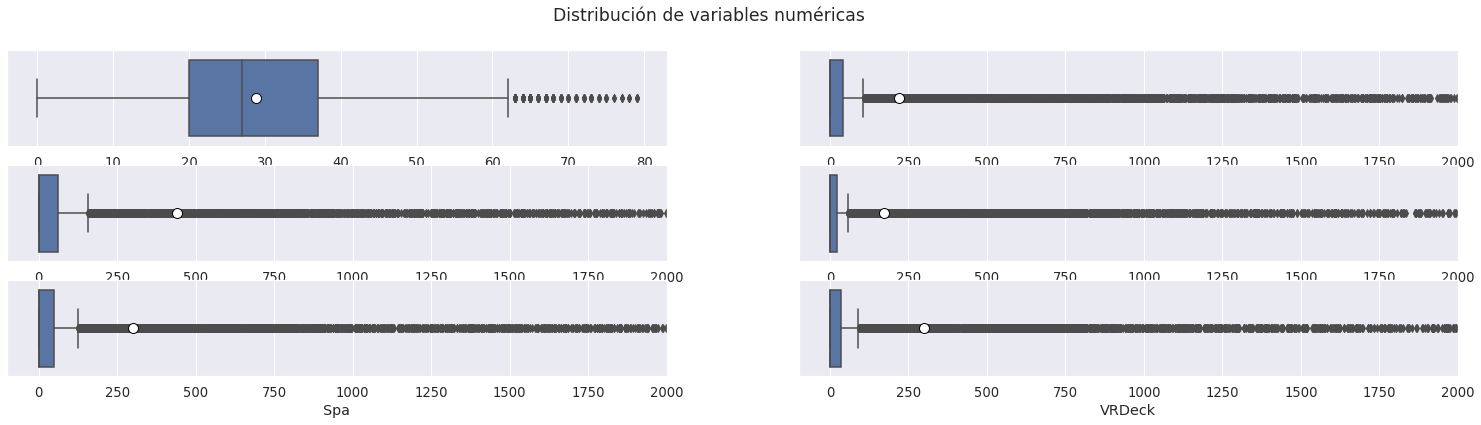

In [392]:
fig, axes = plt.subplots(3, 2, figsize=(26, 6))

fig.suptitle('Distribución de variables numéricas')


sns.boxplot(ax=axes[0, 0], data=df, x='Age', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black","markersize":"10"})
sns.boxplot(ax=axes[0, 1], data=df, x='RoomService', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black","markersize":"10"}).set(xlim=(-100, 2000))
sns.boxplot(ax=axes[1, 0], data=df, x='FoodCourt', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black","markersize":"10"}).set(xlim=(-100, 2000))
sns.boxplot(ax=axes[1, 1], data=df, x='ShoppingMall', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black","markersize":"10"}).set(xlim=(-100, 2000))
sns.boxplot(ax=axes[2, 0], data=df, x='Spa', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black","markersize":"10"}).set(xlim=(-100, 2000))
sns.boxplot(ax=axes[2, 1], data=df, x='VRDeck', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black","markersize":"10"}).set(xlim=(-100, 2000))
            

In [393]:
df[numeric_cols].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_spent
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,28.771969,218.378026,441.890979,170.779491,301.722282,300.450270,1433.221049
std,14.236710,641.766201,1568.038076,584.153630,1118.746785,1168.655639,2807.369708
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,716.000000
75%,37.000000,42.750000,62.750000,23.000000,50.000000,36.000000,1442.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000


En el caso de la **edad**, podemos ver que el 50% de la población más central se encuentra entre los 20 y los 27 años de edad, por lo que la mayoría de los tripulantes son bastante jóvenes. Los datos forman una distribución bastante simética, exceptuando una serie de outliers por la derecha formada por gente mayor de 63 años, lo cual hace que la media suba y por tanto rompe con la simetría. El máximo de edad se encuentra en los 79 años, con lo cual concluimos que en comparación con la esperanza de vida actual, se trata de una población poco longeva.

El resto de las variables relativas a los gastos tienen una forma bastante similar, por lo que las comentaremos a la vez. Se caracterizan por una distribución nada simétrica, en la que la gran mayoría de valores se concentran al principio, de manera que se forma en todas una larga cola por la parte derecha formada por valores considerados outliers. La gran mayoría de genre no suele gastarse grandes cantidades de dinero en los servicios de la nave, ya que en ninguno de los servicios el 75% de los valores más comunes excede los 70 euros. No obstante, las medias de todas las variables se ven muy perjudicadas por la gran cantidad de outliers, al no ser una medida robusta de tendencia central. En resumen, existen muchas personas que se gastan poco en servicios, en contraste con unas pocas personas que se gastan mucho en servicios. En el caso del Spa por ejemplo, mientras la gran mayoría de personas no han excedido un gasto de 50 euros, en otras personas las cantidades gastadas superan los 22.000 euros. Fijándonos en la media, el servicio en el que la gente suele gastarse más dinero es en **FoodCourt**.

### Comprobación de la normalidad y homogeneidad de la varianza <a class="anchor" id="normal"></a>


A continuación realizaremos la comprobación mediante test estadísticos de la normalidad y homocedasticidad entre las varianzas de los diferentes grupos que consideremos interesantes.

Las variables de las que vamos a comprobar la normalidad y la homocedasticidad son **Age** y **Total_spent**, pues son las únicas variables cuantitativas (tomando **Total_spent** como conjunto de las columnas **RoomService, FoodCourt, ShoppingMall, Spa y VRDeck**).

Para comprobar la normalidad de cada una de las columnas vamos a aplicar el test de K-cuadrado de D'Agostino y, para la comprobación de la homocedasticiad, el test de **Levene**.

La prueba de K-cuadrado de D'Agostino prueba la hipótesis nula de que la muestra proviene de una distribución normal y la de Levene prueba la hipótesis nula de que las muestras provienen de poblaciones con varianzas iguales. En ambas ocasiones, si obtenemos un p-valor mayor que 0.05, podemos rechazar la hipótesis nula con un 95% de confianza.

In [394]:
# Prueba de K-cuadrado de D'Agostino
t_stat_norm_age, p_norm_age = normaltest(df_train['Age'])
t_stat_norm_spent, p_norm_spent = normaltest(df_train['Total_spent'])

print("Variable Age:")

if p_norm_age <= 0.05:
    print("P-Value: {} - La muestra no proviene de una población normalmente distribuida".format(p_norm_age))
else:
    print("P-Value: {} - La muestra proviene de una población normalmente distribuida".format(p_norm_age))
    
print("\nVariable Total_spent:")

if p_norm_spent <= 0.05:
    print("P-Value: {} - La muestra no proviene de una población normalmente distribuida".format(p_norm_spent))
else:
    print("P-Value: {} - La muestra proviene de una población normalmente distribuida".format(p_norm_spent))

Variable Age:
P-Value: 1.0490300128101836e-54 - La muestra no proviene de una población normalmente distribuida

Variable Total_spent:
P-Value: 0.0 - La muestra no proviene de una población normalmente distribuida


Parece que ninguna de las 2 variables proviene de una distribución normal. Ahora vamos a comprobar la homogeneidad de la varianza de la edad entre los grupos de pasajeros que fueron transportados y los que no.

In [395]:
muestra_1 = df_train[df_train['Transported']==1]['Age']
muestra_2 = df_train[df_train['Transported']==0]['Age']

# Prueba de K-cuadrado de D'Agostino
t_stat_var, p_var = levene(muestra_1, muestra_2)

print("Variable Age:")

if p_var <= 0.05:
    print("P-Value: {} - Las varianzas no son homogeneas".format(p_norm_age))
else:
    print("P-Value: {} - Las varianzas son homogeneas".format(p_norm_age))

Variable Age:
P-Value: 1.0490300128101836e-54 - Las varianzas no son homogeneas


### Aplicación de pruebas estadísticas  <a class="anchor" id="tests"></a>

En función de lo que hemos observado durante el análisis exploratorio descriptivo, vamos a realizar tres pruebas estadísticas.

#### Correlación entre planeta de origen y si ha sido transportado

Queremos comprobar si las variables **HomePlanet** y **Transported** son dependientes es decir, si influye o no el país de origen del individuo a la hora de predecir si será teletransportado a otra dimensión o no. Al tratarse de dos variables categóticas, utilizaremos la prueba de chi-cuadrado de Pearson. Este test nos permite realizar una prueba de independencia entre ambas variables. 

En primer lugar, calcularemos una tabla de contingencia para resumir la relación entre ambas variables. Podemos ver la cantidad de personas que han sido transportadas y las que no provenientes de cada país de origen.

In [396]:
contingency=pd.crosstab(df_train['HomePlanet'],
                            df_train['Transported'], 
                            margins = False)
pd.crosstab(df_train['HomePlanet'], df_train['Transported'],  margins = True)

Transported,0,1,All
HomePlanet,,,
Earth,2651,1951,4602
Europa,727,1404,2131
Mars,839,920,1759
Origen desconocido,98,103,201
All,4315,4378,8693


In [397]:
chi_val, p, dof, expected = chi2_contingency(contingency)
print(f'chi value:\t\t{chi_val}\np-value:\t\t {p}\ndegrees of freedom:\t {dof}\nexpected values:\n{expected}\n')

print('_______Resultados del test Chi cuadrado_______')
if p <= 0.05:
    print('Variables dependientes (rechazo de H0)')
else:
    print('Variables independientes (aceptación de H0)')

chi value:		324.96723663979583
p-value:		 3.9214919240932375e-70
degrees of freedom:	 3
expected values:
[[2284.32416887 2317.67583113]
 [1057.77809732 1073.22190268]
 [ 873.12607845  885.87392155]
 [  99.77165535  101.22834465]]

_______Resultados del test Chi cuadrado_______
Variables dependientes (rechazo de H0)


Una vez realizado el test, analizamos los resultados obtenidos. En el caso del test de Chi cuadrado, la hipótesis nula () establece que no existe relación entre las variables. Por el contrario, la hipótesis alternativa () afirmaría que existe una relación significativa entre ambas. Observando el p-valor resultante, vemos que se trata de un valor muy cercano a 0, inferior al nivel de significancia 0.05. Por tanto, el error de descartar  sería muy bajo. Se entiende por tanto que el valor resultado del test 324.90 es mayor al valor crítico, cayendo en la zona de rechazo de la hipótesis nula. Podemos afirmar entonces que las variables HomePlanet y Transported son dependientes.

### Intervalos de confianza de la media de la edad

En la siguiente prueba estadística, nos interesa calcular el intervalo de confianza de la edad de los pasajeros. Partimos de la base de que este dataset contiene información de una muestra de pasajeros pertenecientes a una población más grande. Tanto la media  como la desviación típica  de la población se asumen como desconocidas. Es por esto que nos interesa conocer el intervalo de confianza en el que se encuentra la media de edad de la población, calculándolo a partir de la muestra. Sin embargo, debido a que no podemos tener la certeza absoluta de que eso se cumpla para todos los casos (es decir, todas las muestras seleccionadas de la población), se utiliza el nivel de confianza. EN nuestro caso, calcularemos los intervalos de confianza de la media de edad entre las personas **transportadas** y las **no transportadas**, y realizaremos una comparación entre ambos intervalos.

Vamos a empezar separando ambos grupos de estudio.

In [398]:
age_transported = df_train['Age'][df_train['Transported']==1]
age_non_transported = df_train['Age'][df_train['Transported']==0]

En primer lugar, estudiaremos la normalidad de cada uno de los grupos por separado. Para ello representaremos los datos mediante un histograma superponiendo la curva de una distribución normal con la misma media y desviación estándar de cada conjunto.

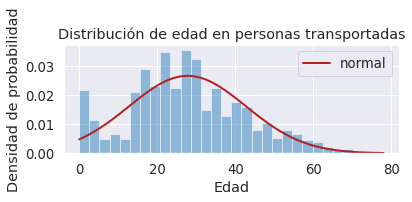

In [399]:
mu, sigma = stats.norm.fit(age_transported)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(age_transported), max(age_transported), num=100)
y_hat = scipy.stats.norm.pdf(x_hat, mu, sigma)


# Graficas de distribución
fig, axes = plt.subplots(figsize=(6,2))


plt.plot(x_hat, y_hat, linewidth=2, label='normal', color='firebrick')
plt.hist(x=age_transported, density=True, bins=30, color="#3182bd", alpha=0.5)
plt.title('Distribución de edad en personas transportadas')
plt.xlabel('Edad')
plt.ylabel('Densidad de probabilidad')
plt.legend()

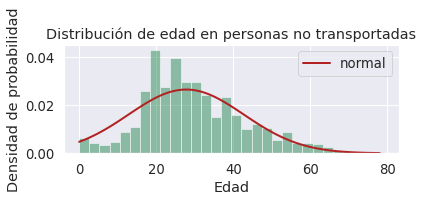

In [400]:
fig, axes = plt.subplots(figsize=(6,2))

plt.plot(x_hat, y_hat, linewidth=2, label='normal', color='firebrick')
plt.hist(x=age_non_transported, density=True, bins=30, color="seagreen", alpha=0.5)
plt.title('Distribución de edad en personas no transportadas')
plt.xlabel('Edad')
plt.ylabel('Densidad de probabilidad')
plt.legend()

Podemos ver que a grandes rasgos, ambas gráficas parecen asemejarse a una distribución normal, pero cuentan con picos muy altos que se salen de la distribución esperada. En el caso de las personas trasnportadas, existe además otro pico de densidad entre las personas más jóvenes de entre 0 y 5 años.

Utilizaremos también gráficos de cuantiles teóricos (Gráficos Q-Q) para realizar una comparación más precisa de la normalidad.

Text(0.5, 1.0, 'Gráfico Q-Q de la edad de las personas transportadas')

<Figure size 216x216 with 0 Axes>

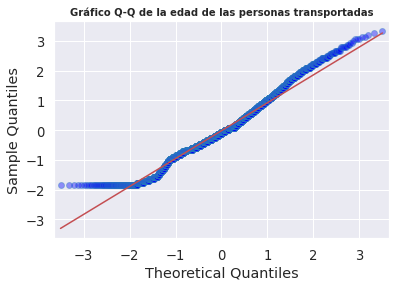

In [401]:
plt.figure(3,figsize=(3,3)) 
sm.qqplot(age_transported,fit= True,line ='q',alpha = 0.4,lw= 2, color="#3182bd", fmt="#3182bd")
plt.title('Gráfico Q-Q de la edad de las personas transportadas', fontsize = 10, fontweight = "bold")

Text(0.5, 1.0, 'Gráfico Q-Q de la edad de las personas no transportadas')

<Figure size 216x216 with 0 Axes>

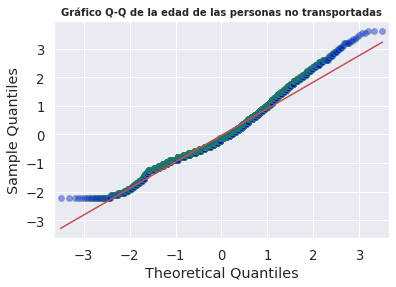

In [402]:
plt.figure(3,figsize=(3,3)) 
sm.qqplot(age_non_transported,fit= True,line ='q',alpha = 0.4,lw= 2,color="seagreen")
plt.title('Gráfico Q-Q de la edad de las personas no transportadas', fontsize = 10, fontweight = "bold")

Para poder decir que los datos siguen una distribución normal, los puntos deberían estar alineados en torno a la recta. Podemos ver que a pesar de que hay zonas en las que coincide, en ninguno de los dos casos se cumple esta alineación de manera evidente, especialmente en en caso de las personas no transportadas. Podemos asumir por tanto que a pesar de que se acercan, **ninguna de los dos grupos sigue una distribución normal**.

Según el Teorema del Límite Central, las medias de las muestras de una población siguen una distribución normal aunque la población no tenga una distribución normal, siempre que el tamaño de las muestras sea suficientemente grande. De este modo, teniendo en cuenta el Teorema del Límite Central y dado que el tamaño de la muestra es lo suficientemnte grande (n > 30), se puede asumir normalidad en la variable. Sin embargo, dado que no se conoce la varianza de la población, la estimaremos a partir de la muestra. Esto significa que usaremos la distribución t de Student en lugar de la distribución normal.

Para calcular el intervalo de confianza en ambos grupos, crearemos una función que recibe los datos y el nivel de confianza.

In [403]:
def mean_confidence_interval(data, confidence):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return f"Mean: {round(m,4)}     Confidence interval:  ({round(m-h,4)}, {round(m+h,4)})"

mean_confidence_interval(age_transported, 0.95)

'Mean: 27.771     Confidence interval:  (27.3267, 28.2153)'

In [404]:
mean_confidence_interval(age_non_transported, 0.95)

'Mean: 29.9003     Confidence interval:  (29.4956, 30.3049)'

Los resultados obtenidos son:

- El intervalo de confianza al 95% de la media de la variable **Age** para las personas transportadas es (27.3255, 28.2142)
- El intervalo de confianza al 95% de la media de la variable **Age** para las personas no transportadas es (29.4945, 30.3038)

Esto significa que, 95 de cada 100 veces que escojamos una muestra aleatoria simple de pasajeros transportados y calculemos el valor de la media muestral nos dará un valor comprendido en el intervalo (27.3255, 28.2142). En el caso del otro grupo, 95 de cada 100 veces que escojamos una muestra aleatoria simple de pasajeros no transportados y calculemos el valor de la media muestral nos dará un valor comprendido en el intervalo 29.4945, 30.3038).

El intervalo de confianza de la media de las personas transportadas comprende un rango de valores un poco más grande que el de las personas no transportadas. Podemos ver que no existe solapamiento entre los intervalos de confianza de las medias muestrales. Además como puede observarse, el de las personas no transportadas recoge valores más altos. Esto quiere decir que, con una confianza del 95% podríamos llegar a intuir que las personas no transportadas son de media más mayores que las personas transportadas. No obstante, para poder corroborar esto de manera fiable tendríamos que realizar un contraste de hipótesis entre las medias de ambas muestras.

####  Media de la edad de los pasajeros que han sido transportados y los que no

Siguiendo con la prueba anterior, vamos a realizar una prueba t de Student para comprobar si la media de la edad de los pasajeros que han sido transportados es igual a la de los pasajeros que no han sido transportados o, por el contrario, hay una diferencia significativa.

Las hipotesis que se plantean son:

- **H0**: La hipotesis nula - Las medias de las 2 muestras son idénticas
- **H1**: La hipotesis alternativa - Las medias no son iguales

In [405]:
muestra_1 = df_train[df_train['Transported']==1]['Age']
muestra_2 = df_train[df_train['Transported']==0]['Age']

t_stat, p = ttest_ind(muestra_1, muestra_2)

if p <= 0.05:
    print("P-Value: {} - Hay diferencia entre las 2 variables".format(round(p,3)))
else:
    print("P-Value: {} - No hay diferencia entre las 2 variables".format(round(p,3)))

P-Value: 0.0 - Hay diferencia entre las 2 variables


Al obtener un p-valor = 0.0, podemos rechazar la hipótesis nula con una confianza del 95% y asumir que la media de la edad de los pasajeros que han sido transportados es distinta de los no transportados.

# Conclusiones  <a class="anchor" id="conclussion"></a>

Como el objetivo original del conjunto de datos es predecir los pasajeros que van a ser transportados a otra dimensión está fuera del alcance de este documento, nos enfocaremos en el análisis de datos realizados para estimar cuáles son los pasajeros que tienen menos posibilidades se haber sido transportados:

- Aunque el grupo de pasajero Origen-Destino más numeroso es el que va desde La Tierra a TRAPPIST-1e, se han salvado aproximadamente el mismo numero de pasajeros que los han sido transportados.

- Las diferencias más significativas se aprecian entre los pasajeros en animación suspendida y los que no y los pasajeros que viajan a Europa y Marte.

- Si juntamos los criterios del punto anterior, obtenemos que apenas hay pasajeros en animación suspendida que venían de Europa que hayan conseguido salvarse de ser transportados a otra dimensión. En menor medida pero igualmente destacable son los pasajeros de Marte en animación suspendida.

- Sería lógico pensar los pasajeros de uno de los lados de la nave (babor o estribor) estarían más afectados que otros y más al estar en animación suspendida, pues estarían confinados en sus cabinas. Sin embargo, no se aprecia una diferencia entre ellos.


# Tabla de contribuciones


| Contribuciones              	| Firma 	|
|-----------------------------	|-------	|
| Investigación previa        	| ACG, DGS   	|
| Redacción de las respuestas 	| ACG, DGS   	|
| Desarrollo código           	| ACG, DGS   	|